In [2]:
# General imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch.utils.data import DataLoader, Dataset
from ray import tune, train
from ray.air import session
from ray.tune.schedulers import ASHAScheduler

# Define data paths
GROUP_FEATURES_PATH = '../data/benchmark/virtual/stress-434'
GROUP_LABELS_PATH = '../data/benchmark/real/stress-434'
TEST_FEATURES_PATH = '../data/benchmark/test/vstress434_16.csv'
TEST_LABELS_PATH = '../data/benchmark/test/stress434_4.csv'
NUM_EPOCHS = 100
device = "cuda" if torch.cuda.is_available() else "cpu"

# Function to load and preprocess data
def load_and_preprocess_csv(feature_csv_path, label_csv_path):
    features_df = pd.read_csv(feature_csv_path)[['cpu_usage_latest']]
    labels_df = pd.read_csv(label_csv_path)[['cpu_usage_latest']]
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_df)
    labels = labels_df.values
    return features_scaled, labels

# Function to process groups of files
def process_group(feature_folder_path, label_folder_path):
    feature_files = [os.path.join(feature_folder_path, file) for file in os.listdir(feature_folder_path) if file.endswith('.csv')]
    label_files = [os.path.join(label_folder_path, file) for file in os.listdir(label_folder_path) if file.endswith('.csv')]

    min_length = float('inf')
    features, labels = [], []

    for feature_file, label_file in zip(feature_files, label_files):
        features_df = pd.read_csv(feature_file)[['cpu_usage_latest']]
        labels_df = pd.read_csv(label_file)[['cpu_usage_latest']]
        min_length = min(min_length, len(features_df), len(labels_df))

    for feature_file, label_file in zip(feature_files, label_files):
        features_scaled, labels_data = load_and_preprocess_csv(feature_file, label_file)
        features.append(features_scaled[:min_length])
        labels.append(labels_data[:min_length])

    features_concat = np.concatenate(features)
    labels_concat = np.concatenate(labels)
    print(f"Total concatenated features rows: {features_concat.shape[0]}, labels rows: {labels_concat.shape[0]}")

    return features_concat, labels_concat

# Custom modules for TCN
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.05):
        super().__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2, output_size=1):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                        dilation=dilation_size, padding=(kernel_size-1) * dilation_size,
                                        dropout=dropout))
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)  # Maps to the desired output size

    def forward(self, x):
        x = self.network(x)
        x = x[:, :, -1]  # Take the last timestep output (if you're predicting the next value from the sequence)
        return self.linear(x)

class TimeSeriesDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def validate(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = nn.MSELoss()(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(data_loader)


def plot_predictions(predictions, actuals):
    print(f"Plotting Predictions length: {len(predictions)}, Actuals length: {len(actuals)}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(actuals[:, 0], label='Actual', color='royalblue', linestyle='-', linewidth=1, alpha=0.9)

    # Cargar y plotear la columna 'cpu_usage_latest' de cada serie temporal adicional en el directorio
    colors = plt.cm.viridis(np.linspace(0, 1, len(os.listdir(GROUP_LABELS_PATH))))
    for idx, file_name in enumerate(os.listdir(GROUP_LABELS_PATH)):
        if file_name.endswith('.csv'):
            data_path = os.path.join(GROUP_LABELS_PATH, file_name)
            series_data = pd.read_csv(data_path)
            plt.plot(series_data['cpu_usage_latest'], label=file_name.split('.')[0] + ' CPU Usage', color=colors[idx], linestyle='-', linewidth=1, alpha=0.7)

    # Ploteo de las predicciones y los datos reales
    plt.plot(predictions[:, 0], label='Predicted', color='orangered', linestyle='--', linewidth=2.5, alpha=0.9)

    plt.title('TCN Model Predictions vs. Actuals')
    plt.xlabel('Time Step')
    plt.ylabel('CPU Usage')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.show()


def predict(model, data_loader, device):
    model.eval()
    predictions = []
    actuals = []
    sample_count = 0
    with torch.no_grad():
        for features, labels in data_loader:
            features = features.to(device)
            output = model(features)
            predictions.extend(output.cpu().numpy())
            actuals.extend(labels.numpy())
            sample_count += features.size(0)
    print(f"Predicted samples: {len(predictions)}, Actual samples: {len(actuals)}, Total processed samples: {sample_count}")
    return np.array(predictions), np.array(actuals)


def train_tcn(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Load data and create datasets and dataloaders
    train_dataset = TimeSeriesDataset(training_features, training_labels)
    train_loader = DataLoader(train_dataset, batch_size=int(config["batch_size"]), shuffle=True)
    test_dataset = TimeSeriesDataset(test_features_scaled, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=int(config["batch_size"]), shuffle=False)

    # Initialize model
    model = TemporalConvNet(num_inputs=1, num_channels=config["num_channels"], kernel_size=3, dropout=0.2, output_size=1)
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    # Training loop
    for epoch in range(NUM_EPOCHS):
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation step
        val_loss = validate(model, test_loader, device)
        
        session.report({"loss": val_loss})


def train_model_from_scratch(best_config):
    train_dataset = TimeSeriesDataset(training_features, training_labels)
    train_loader = DataLoader(train_dataset, batch_size=int(best_config["batch_size"]), shuffle=True)
    test_dataset = TimeSeriesDataset(test_features_scaled, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=int(best_config["batch_size"]), shuffle=False)

    model = TemporalConvNet(num_inputs=1, num_channels=best_config["num_channels"], kernel_size=best_config["kernel_size"], dropout=0.05, output_size=1)
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=best_config["lr"])

    for epoch in range(NUM_EPOCHS):  # Train for a full 100 epochs
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        val_loss = validate(model, test_loader, device)
        print(f'Epoch {epoch+1}: Validation Loss = {val_loss}')

    return model

Total concatenated features rows: 576, labels rows: 576
Epoch 1: Validation Loss = 13762932.0
Epoch 2: Validation Loss = 13762213.0
Epoch 3: Validation Loss = 13761350.0
Epoch 4: Validation Loss = 13760244.0
Epoch 5: Validation Loss = 13758738.0
Epoch 6: Validation Loss = 13756588.0
Epoch 7: Validation Loss = 13753413.0
Epoch 8: Validation Loss = 13748664.0
Epoch 9: Validation Loss = 13741481.0
Epoch 10: Validation Loss = 13730526.0
Epoch 11: Validation Loss = 13713662.0
Epoch 12: Validation Loss = 13687469.0
Epoch 13: Validation Loss = 13646605.0
Epoch 14: Validation Loss = 13582658.0
Epoch 15: Validation Loss = 13482876.0
Epoch 16: Validation Loss = 13326932.0
Epoch 17: Validation Loss = 13084052.0
Epoch 18: Validation Loss = 12707630.0
Epoch 19: Validation Loss = 12131206.0
Epoch 20: Validation Loss = 11260178.0
Epoch 21: Validation Loss = 9974814.0
Epoch 22: Validation Loss = 8152167.0
Epoch 23: Validation Loss = 5750889.0
Epoch 24: Validation Loss = 3052407.0
Epoch 25: Validation 

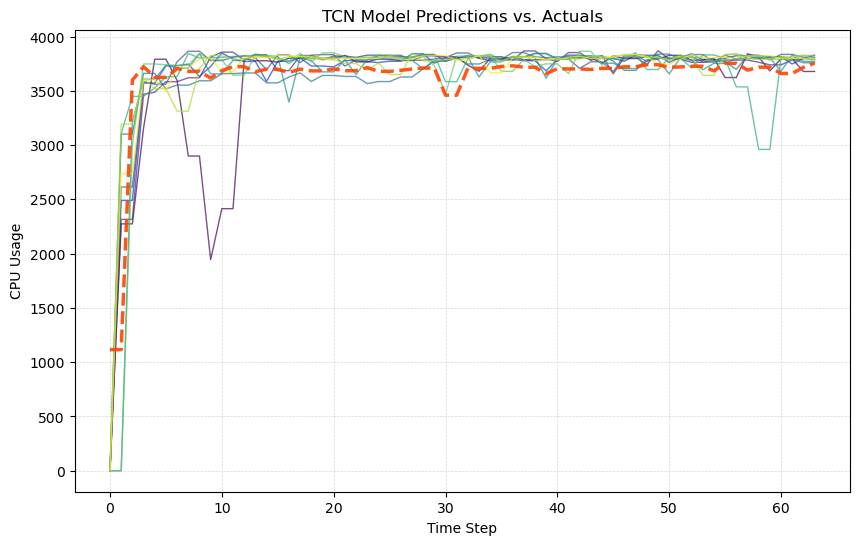

In [3]:

training_features, training_labels = process_group(GROUP_FEATURES_PATH, GROUP_LABELS_PATH)
test_features_scaled, test_labels = load_and_preprocess_csv(TEST_FEATURES_PATH, TEST_LABELS_PATH)

""" config = {
    "lr": tune.loguniform(1e-4, 1e-2),
    "batch_size": tune.choice([64, 128, 256]),
    "num_channels": tune.choice([[16, 32, 64, 128, 256], [32, 64, 128, 256, 512], [4, 8, 16, 32, 64, 128, 256], [64, 128, 256, 512]])
}
scheduler = ASHAScheduler(metric="loss", mode="min", max_t=15, grace_period=2, reduction_factor=2)

analysis = tune.run(
    train_tcn,
    resources_per_trial={"cpu": 16, "gpu": 1},
    config=config,
    num_samples=30,
    scheduler=scheduler,
    progress_reporter=tune.CLIReporter(metric_columns=["loss", "training_iteration"])
)

best_trial = analysis.get_best_trial("loss", "min", "last")
best_config = best_trial.config
print(f"Best config: {best_config}") """

best_config = {'lr': 0.0003, 'batch_size': 512, 'num_channels': [16, 32, 64, 128, 256, 512], 'kernel_size': 4}

# Train the model from scratch with the best configuration
model = train_model_from_scratch(best_config)

# Evaluate the fully trained model
test_dataset = TimeSeriesDataset(test_features_scaled, test_labels)
test_loader = DataLoader(test_dataset, shuffle=False)
predictions, actuals = predict(model, test_loader, device)

# Plot predictions vs actuals
plot_predictions(predictions, actuals)